## Simple Epidemic Model
Date: 2020-03-14  

Watched this interesting video from professor Tom Britton, and decided to put it into python. 

* Mathematics of the Corona outbreak - with professor Tom Britton  
https://www.youtube.com/watch?v=gSqIwXl6IjQ

### Assumptions: 
1. The population has no prior immunity
2. All individuals are similar in terms of susceptibility and infectivity and mix uniformity
3. Recovered individuals becomes immune.
4. No behavioural changes during course of epidemic

### Model
* Discrete time. (week by week, or here abstract into step by step)
* $N$ popluation size.
* Start 1 infectious, $N-1$ susceptible
* Every infectious indiviual infect all the rest of population with probability $p$ during each time step and then **recover**. So essentially every timestep it is only the newly infected from the last timestep that are infectious.
* Goes on till no new infected.

### Basic reproduction numner $R_0$
$R_0$: average number of new infections caused bu a typical infected during early phase of an outbreek.

\begin{align*}
R_0 = (N-1)*p
\end{align*}

If $N = 1000$ and $p = 0.0015$ then  

\begin{align*}
R_0 \sim 1.4985
\end{align*}

### Simulate the Model 10 000 times

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# simulation
total_infected, time_steps = [],[]

for tt in range(10000):
    R = 999*0.0015
    time_step = 0
    s = 1 # number of sick person to start
    N = 1000 # population total
    del_s = s #start value of newly infected =s
    ppl_infected = [s]
    ppl_remain = N-s
    while del_s >0 and ppl_remain >0:
        time_step = time_step + 1
        nbr_trial, prob = del_s, 0.0015
        infections = np.random.binomial(nbr_trial, prob, ppl_remain)
        del_s = np.sum(infections >=1) # newly infected
        s = s + del_s # over all ever infected
        ppl_remain = N-s
    
    total_infected.append(s)
    time_steps.append(time_step)
df_1 = pd.DataFrame({'time_steps':time_steps,
                   'total_infected':total_infected
                  })

### Distribution of total infected

Text(0.5, 0, 'nbr_infection')

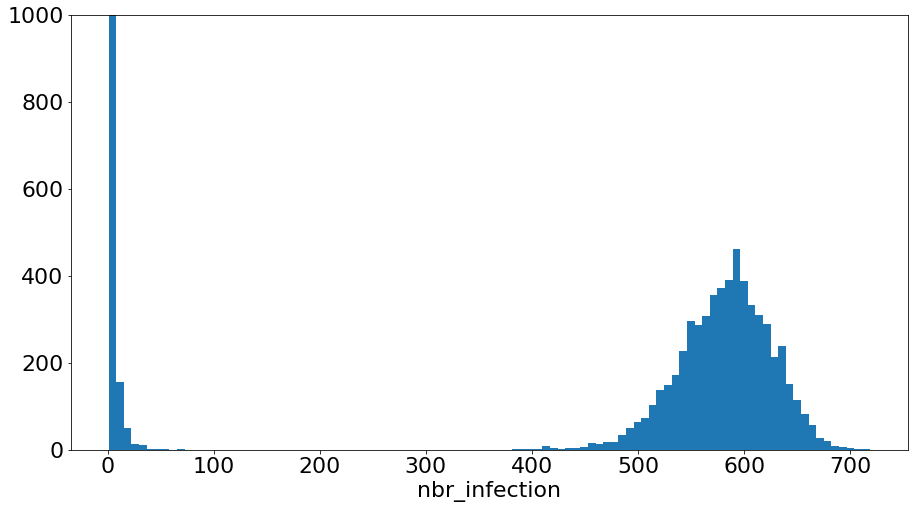

In [3]:
plt.rcParams.update({'font.size': 22})
f, ax = plt.subplots(1,1,figsize = (15,8))
_ = ax.hist(df_1.total_infected, bins = 100)
plt.ylim([0,1000])
plt.xlabel('nbr_infection')

In [4]:
#_ = plt.hist(df.time_steps, bins = 100)
# plt.ylim([0,1000])

Text(0, 0.5, 'nbr_infection')

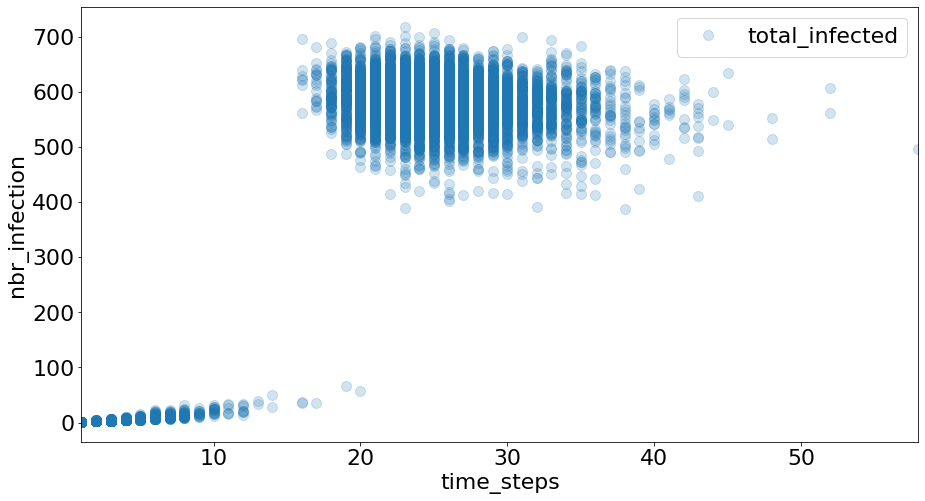

In [5]:
plt.rcParams.update({'font.size': 22})
f, ax = plt.subplots(1,1,figsize = (15,8))
df_1.set_index('time_steps').plot(ax = ax, linestyle = 'None', marker = '.', ms = 20, alpha = 0.2)
plt.ylabel('nbr_infection')

Most of the cases, the epidemic last 20-40 timesteps (weeks) and infect 500-700 people in total, given total population is 1000 and $R_0 \sim$ 1.5.

### Equation and solution for total infected population fraction $\tau$ 
### 1. Simple model with one type of population response to infection
Since $1-\tau$ should be the probability of not getting infected while exposed to $N\tau$ infectious trials, $\tau$ should satisfy the following condition:

(eq. 1)
\begin{align*}
 1 - \tau &= (1-p)^{N\tau} \\
      &= (1-\frac{R_0}{N})^{N\tau} \\
      &= (1-\frac{1}{{N}/{R_0}})^{\frac{N}{R_0}*R_0\tau} \\
      &= e^{-R_0\tau}
\end{align*}                                                    


### 2. Model with two type of population responses to infection
In a slightly more mixed situation, fraction $w$ of the population could be less suceptible to the virus, and having a fraction $v$ of the original suceptibility $p$. So the equaction becomes:  
(eq. 2)  

\begin{align*}
1 - \tau &= (1-p)^{N(1-w)\tau}(1-vp)^{Nw\tau} \\
      &= (1-\frac{R_0}{N})^{N(1-w)\tau} (1-\frac{vR_0}{N})^{Nw\tau} \\
      &= (1-\frac{1}{{N}/{R_0}})^{\frac{N}{R_0}*R_0(1-w)\tau}(1-\frac{1}{(1/v)(N/R_0)})^{(1/v)(N/R_0)*vR_0w\tau} \\
      &= e^{-R_0(1-w)\tau}e^{-R_0vw\tau}\\
      &= e^{-R_0\tau(1-w+vw)}
\end{align*}
(eq.2) becomes (eq.1) when $w = 0$. 

### Solving numerically $\tau$, $R_0$ in range $\tau = 0 \sim 1$ given $R_0 = 0 \sim 10$ for simple case and mixed case:

In [9]:
def eq_mix(tau, R, w, v):
    return np.abs(1-tau-np.exp(-R*tau*(1-w+w*v)))

def solve_eq(eq, w, v, tau_range = np.arange(0,1,0.001), R_range = np.arange(0, 20, 0.01)):
    tt, rr = np.meshgrid(tau_range, R_range)
    rs = np.array([R_range[i] for i in eq(tt, rr, w=w, v=v).argmin(axis = 0)])
    res = np.array([eq(tt, rr, w=w, v=v) for tt, rr in zip(tau_range, rs) ])
    tau, rs =  tau_range[res<1e-3], rs[res<1e-3]
    tau, rs = np.insert(tau,len(tau), max(tau_range)), np.insert(rs, len(rs), max(R_range))
    return tau, rs

In [15]:
# simple case w = 0, v = 1 the same as 
tau0, rs0 = solve_eq(eq=eq_mix, w = 0, v=1)
label0 = 'all equaly susceptible'

# mixed case w = 0.5, v = 0.5 the same as 
tau1, rs1 = solve_eq(eq=eq_mix, w = 0.5, v=0.5)
label1 = 'half the ppl. is half susceptible'

# mixed case w = 0.7, v = 0 the same as 
tau2, rs2 = solve_eq(eq=eq_mix, w = 0.7, v=0)
label2 = '70% the ppl. are vaccinated'

# mixed case w = 0.9, v = 0 the same as 
tau3, rs3 = solve_eq(eq=eq_mix, w = 0.9, v=0)
label3 = '90% the ppl. are vaccinated'


# mixed case w = 0.9, v = 0 the same as 
tau4, rs4 = solve_eq(eq=eq_mix, w = 0.99, v=0)
label4 = '99% the ppl. is vaccinated'

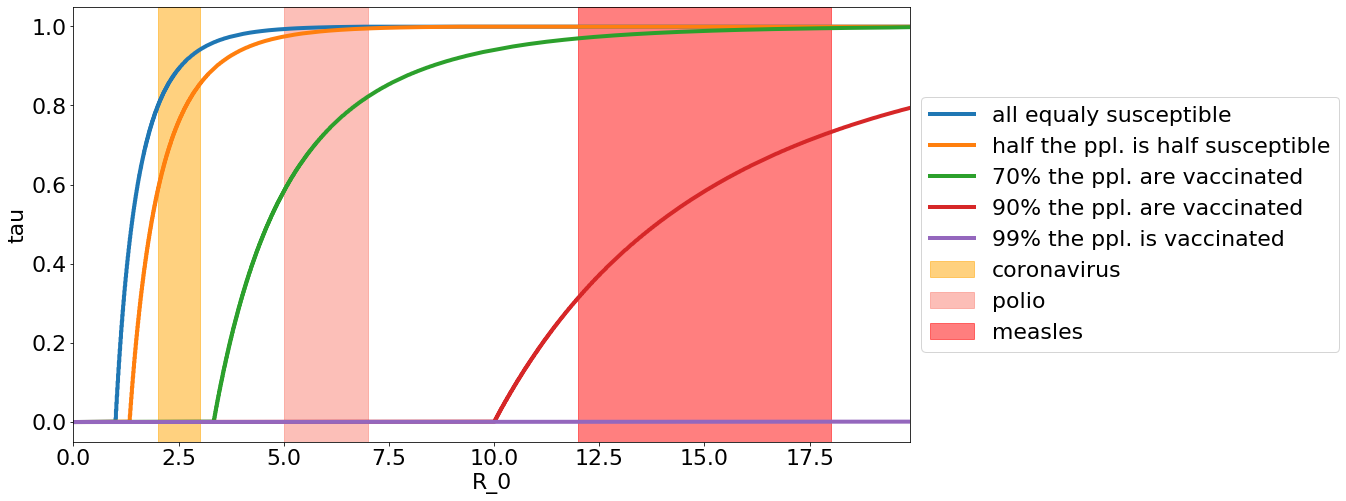

In [17]:
plt.rcParams.update({'font.size': 22})
f, ax = plt.subplots(1,1,figsize = (15,8))
plt.xlabel('R_0')
plt.ylabel('tau')

ax.plot(rs0, tau0, label = label0 ,linewidth = 4)
ax.plot(rs1, tau1, label = label1 ,linewidth = 4)
ax.plot(rs2, tau2, label = label2 ,linewidth = 4)
ax.plot(rs3, tau3, label = label3 ,linewidth = 4)
ax.plot(rs4, tau4, label = label4 ,linewidth = 4)
ax.axvspan(2, 3, alpha=0.5, color='orange', label = 'coronavirus')
ax.axvspan(5, 7, alpha=0.5, color='salmon', label = 'polio')
ax.axvspan(12, 18, alpha=0.5, color='red', label = 'measles')
plt.xlim([0,19.9])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



### Importance of vaccination
It is evident that with less suceptible population the less total infection we end up with. With 70% vaccination the total population can be safe for viruses with moderate $R_0$ values such as coronavirus ($R_0 \sim 2-3$ ). If 90% of the population are vaccinated., the outbreak infectious diseases such as polio ($R_0 \sim 5-7$) can be prevented, but not for measles ($R_0 \sim 12-18$ ). With 99% vaccination rate, the outbreak of very infectious measles can be safely prevented too. 

### Peak infection as influenced by $R_0$

$R_0$ can be factorized:

\begin{align*}
R_0 = pcl
\end{align*}
where
* $p$: transmission probability of a contact.   
* $c$: number of c "contacs" per day  
* $l$: duration of infectious period  

Prevention measures that decreases $R_0$:  

* $p$: face mask, hand-washing, condom ...
* $c$: quarantine, avoid crowds, avoid public transports ...
* $l$: quicker diagnosis, isolation

Given 100 timesteps (weeks) get peak infections graph by simulating 1000 times. 

In [16]:

n_simulations = 1000
n_timesteps = 100
infection_cases = np.zeros(n_timesteps)

dfs = []
for R in (0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25):
    for tt in range(n_simulations):
        s = 1 # number of sick person to start
        N = 1000 # population total
        del_s = s #start value of newly infected =s
        ppl_infected = np.zeros(n_timesteps)
        ppl_infected[0] = s
        for timestep in np.arange(n_timesteps-1):
            if del_s >0 and ppl_remain >0:
                ppl_remain = N-s
                nbr_trial, prob = del_s, R/N
                infections = np.random.binomial(nbr_trial, prob, ppl_remain)
                del_s = np.sum(infections >=1) # newly infected
                ppl_infected[timestep+1] = del_s
                s = int(ppl_infected.sum())
        infection_cases = infection_cases+ppl_infected

    infection_cases = infection_cases/n_simulations
    dfs.append(pd.DataFrame({f'R = {R}':infection_cases}))
df = pd.concat(dfs, axis = 1)

Text(0, 0.5, 'newly infected')

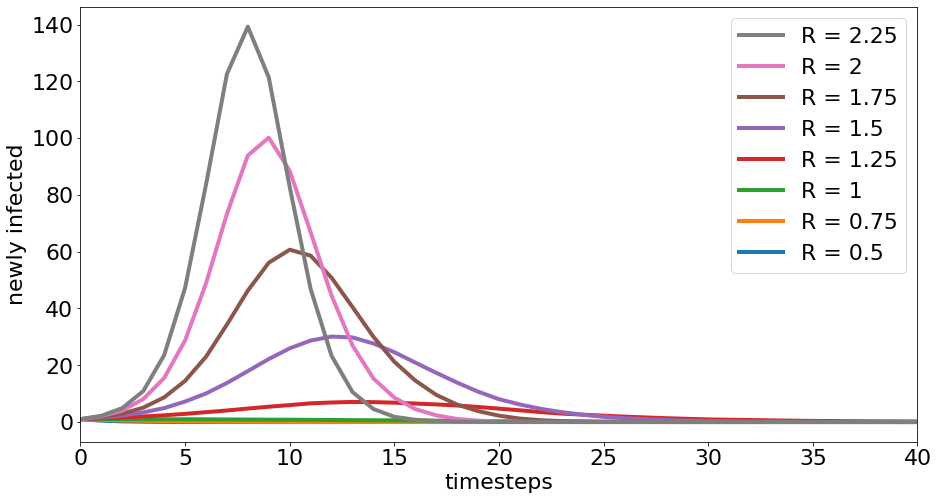

In [17]:
plt.rcParams.update({'font.size': 22})
f, ax = plt.subplots(1,1,figsize = (15,8))
df.plot(ax = ax, linewidth = 4)
plt.xlim([0, 40])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best')
plt.xlabel('timesteps')
plt.ylabel('newly infected')


With $R_0$ reduced, the peak can be much smaller and much delayed. So prevention measures such as masks, hand-washing, quarantine, isolation can reduce the load on the healthcare systems. 